# CCM counter example classification

The following example shows that CCM may not be better than STD

In [1]:
import sys
import numpy as np
from graphviz import Digraph, Source
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sympy import Matrix, simplify, symbols
from sympy.solvers.solveset import linsolve

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.flow import Graph, Node, sample_graph
from lib.data import SubColumn
from lib.models import MLP, CCM_res, SubColumnNet
from lib.train import train_step_standard, train_step_xyc, train
from lib.regularization import EYE
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap

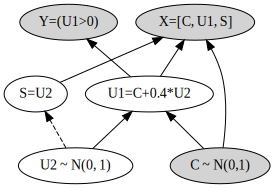

In [2]:
dot = Digraph()

dot.node('X', 'X=[C, U1, S]', style='filled', fillcolor='lightgray')
dot.node('C', 'C ~ N(0,1)', style='filled', fillcolor='lightgray')
dot.node('Y', 'Y=(U1>0)', style='filled', fillcolor='lightgray')
dot.node('U', 'U1=C+0.4*U2')
dot.node('Z', 'U2 ~ N(0, 1)')
dot.node('S', 'S=U2')
dot.edges(['UY', 'CU', 'ZU', 'UX', 'SX', 'CX'])
dot.edge('Z', 'S', style='dashed')

dot.graph_attr['rankdir'] = 'BT'
dot.render('figures/counter_example')
dot

This case is interesting b/c the problem is linear and C for sure is relevant for predicting Y.

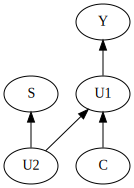

          C        U2         S        U1  Y
0 -0.246154  1.137302  1.137302  0.208766  1
1  0.960880  0.719868  0.719868  1.248828  1
2 -1.179297  0.123116  0.123116 -1.130051  0
3  0.103324  1.193383  1.193383  0.580678  1
4  0.444241  0.783221  0.783221  0.757529  1
5  0.424913 -0.268631 -0.268631  0.317461  1
6 -2.161318 -0.142024 -0.142024 -2.218128  0
7 -0.343487  0.289454  0.289454 -0.227706  0
8 -0.153784  0.796497  0.796497  0.164815  1
9 -0.988954 -2.064016 -2.064016 -1.814561  0


,C,U2,S,U1,Y
0,0.645523,-1.185751,0.0,0.171223,1
1,0.877869,-0.506639,0.0,0.675213,1
2,-0.696659,0.108827,0.0,-0.653128,0
3,0.424835,0.813688,0.0,0.750310,1
4,-0.237636,1.224664,0.0,0.252229,1
5,-0.208598,-0.299303,0.0,-0.328320,0
6,-0.898903,-1.085237,0.0,-1.332998,0
7,-0.236436,0.916941,0.0,0.130340,1
8,-0.754495,1.172805,0.0,-0.285372,0
9,2.117164,1.107201,0.0,2.560045,1


In [3]:
def build_graph():
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    c = Node('C')
    u2 = Node('U2')
    s = Node('S', lambda u2: u2, [u2])
    u1 = Node('U1', lambda c, u2: c + 0.4 * u2, [c, u2])
    y  = Node('Y', lambda u1: (u1 > 0).astype(int),
              [u1], is_target_node=True)
    
    # initialize the values from data
    graph = Graph([c, u1, u2, s, y])   
    return graph

graph = build_graph() # the causal graph
graph.draw()
n = 10
print(sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']])
sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U2', 'S', 'U1', 'Y']]

In [4]:
n = 100000
bs = 100
wd = 1e-4

XYC = sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]
XYC_te = sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n)})[['C', 'U2', 'S', 'U1', 'Y']]
XYC_deploy = sample_graph(graph, {'C': np.random.randn(n), 'U2': np.random.randn(n), 'S': np.zeros(n)})[['C', 'U2', 'S', 'U1', 'Y']]

def get_X_Y_C(XYC):
    X = np.array(XYC[['C', 'U1', 'S']])
    Y = np.array(XYC[['Y']]).ravel()
    C = np.array(XYC[['C']])
    return torch.from_numpy(X).float(), torch.from_numpy(Y).long(), torch.from_numpy(C).float()

X, Y, C = get_X_Y_C(XYC)
d = X.shape[1]
X_te, Y_te, C_te = get_X_Y_C(XYC_te)
X_de, Y_de, C_de = get_X_Y_C(XYC_deploy)
r = torch.zeros(d) # concept mask
r[0] = 1

# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
loader_xy = DataLoader(TensorDataset(X, Y), batch_size=bs, shuffle=True) # regular dataset
loader_xy_te = DataLoader(TensorDataset(X_te, Y_te), batch_size=bs, shuffle=False) # regular dataset
loader_xy_de = DataLoader(TensorDataset(X_de, Y_de), batch_size=bs, shuffle=False) # regular dataset

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 883.20it/s]


epoch   2: loss 1.057e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 925.02it/s]


epoch   5: loss 5.910e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 902.68it/s]


epoch   8: loss 3.945e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 790.48it/s]


epoch  11: loss 2.960e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 713.15it/s]


epoch  14: loss 2.454e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 763.54it/s]


epoch  17: loss 2.255e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 647.57it/s]


epoch  20: loss 2.215e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 780.04it/s]


epoch  23: loss 2.201e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 656.16it/s]


epoch  26: loss 2.187e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 892.44it/s]


epoch  29: loss 2.179e-02


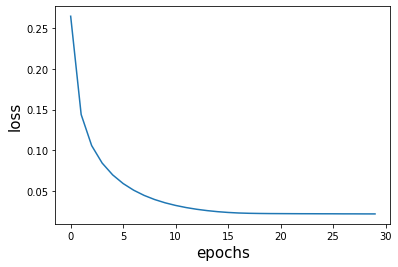

In [5]:
def standard_model(loader_xy, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([d, 2])
    
    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 30
STD = standard_model(loader_xy, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [6]:
# ['C', 'U1=C+0.4*U2', 'S=U2']
STD.classifier[0].weight[1] - STD.classifier[0].weight[0]

tensor([11.1377, 16.2503,  4.4708], grad_fn=<SubBackward0>)

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 705.25it/s]


epoch   2: loss 1.135e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 706.00it/s]


epoch   5: loss 8.465e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 687.77it/s]


epoch   8: loss 7.772e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 716.08it/s]


epoch  11: loss 7.387e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 537.24it/s]


epoch  14: loss 7.007e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 697.23it/s]


epoch  17: loss 6.658e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 562.51it/s]


epoch  20: loss 6.427e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 550.21it/s]


epoch  23: loss 6.322e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 679.01it/s]


epoch  26: loss 6.266e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 665.63it/s]


epoch  29: loss 6.235e-02


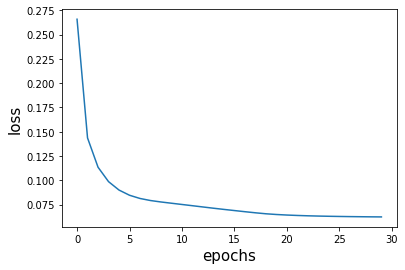

In [7]:
def CCM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    # regular model
    net = MLP([len(r), 2])

    # train
    # criterion = lambda o_y, y: F.cross_entropy(o_y, y) + 0.01 * (net.classifier[0].weight[1] - net.classifier[0].weight[0])[1:].abs().sum()
    criterion = lambda o_y, y: F.cross_entropy(o_y, y) + 0.0009 * EYE(r, (net.classifier[0].weight[1] - net.classifier[0].weight[0])[1:].abs().sum())
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, criterion=criterion)
    if plot: plot_log(log)
    return net

n_epochs = 30
ccm = CCM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [8]:
# ['C', 'U1=C+0.4*U2', 'S=U2']
ccm.classifier[0].weight[1] - ccm.classifier[0].weight[0]

tensor([ 1.5390e+01, -1.3262e-05,  5.9983e+00], grad_fn=<SubBackward0>)

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 865.13it/s]


epoch   2: loss 2.956e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 621.51it/s]


epoch   5: loss 2.667e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 825.42it/s]


epoch   8: loss 2.660e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 708.91it/s]


epoch  11: loss 2.660e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 629.68it/s]


epoch  14: loss 2.660e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 776.40it/s]


epoch  17: loss 2.660e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 863.48it/s]


epoch  20: loss 2.660e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 862.15it/s]


epoch  23: loss 2.660e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 877.85it/s]


epoch  26: loss 2.660e-01


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 792.42it/s]


epoch  29: loss 2.660e-01


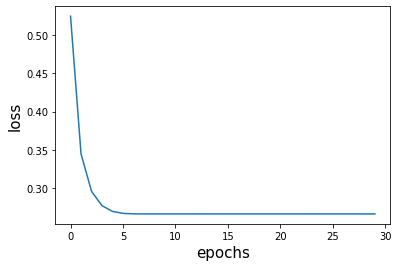

In [9]:
def CBM(loader_xy, r, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = nn.Sequential(SubColumnNet(r.bool()), MLP([int(sum(r).item()), 2]))

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 30
cbm = CBM(loader_xy, r, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [10]:
cbm[1].classifier[0].weight[1] - cbm[1].classifier[0].weight[0], [p for p in cbm[1].classifier.parameters()]

(tensor([4.4131], grad_fn=<SubBackward0>),
 [Parameter containing:
  tensor([[-1.9216],
          [ 2.4915]], requires_grad=True),
  Parameter containing:
  tensor([0.6411, 0.6538], requires_grad=True)])

train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 581.44it/s]


epoch   2: loss 6.179e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 605.90it/s]


epoch   5: loss 3.881e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 640.64it/s]


epoch   8: loss 2.896e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 826.58it/s]


epoch  11: loss 2.384e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 705.07it/s]


epoch  14: loss 2.157e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 799.38it/s]


epoch  17: loss 2.108e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 658.74it/s]


epoch  20: loss 2.095e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 708.12it/s]


epoch  23: loss 2.083e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 537.91it/s]


epoch  26: loss 2.075e-02


train step for 1 epoch: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 541.38it/s]


epoch  29: loss 2.069e-02


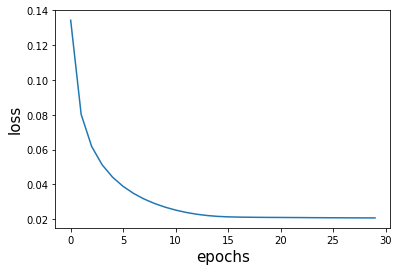

In [12]:
def Res(loader_xy, cbm, d, n_epochs=10, report_every=1, plot=True, weight_decay=0):
    net = MLP([d, 2])    
    net = CCM_res(cbm, net)

    # train
    opt = optim.Adam(net.parameters(), weight_decay=weight_decay)
    # opt = optim.SGD(net.parameters(), lr=0.01, weight_decay=weight_decay)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every)
    if plot: plot_log(log)
    return net

n_epochs = 30
res = Res(loader_xy, cbm, d, n_epochs=n_epochs, report_every=max(n_epochs//10,1), weight_decay=wd)

In [13]:
res.net2.classifier[0].weight[1] - res.net2.classifier[0].weight[0]

tensor([ 9.8165, 14.6328,  5.6863], grad_fn=<SubBackward0>)

In [14]:
print('task acc after training: {:.1f}%'.format(test(res, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(ccm, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(cbm, loader_xy_te, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(STD, loader_xy_te, acc_criterion) * 100))

test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 663.04it/s]


task acc after training: 100.0%


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 868.22it/s]


task acc after training: 99.7%


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 912.89it/s]


task acc after training: 87.9%


test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 921.26it/s]

task acc after training: 100.0%


In [15]:
print('task acc after training: {:.1f}%'.format(test(res, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(ccm, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(cbm, loader_xy_de, acc_criterion) * 100))
print('task acc after training: {:.1f}%'.format(test(STD, loader_xy_de, acc_criterion) * 100))

test eval: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 807.19it/s]


task acc after training: 94.3%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1067.80it/s]


task acc after training: 88.0%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1340.16it/s]


task acc after training: 88.0%


test eval: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1219.56it/s]

task acc after training: 95.3%


# Regression

$$min_\theta \mathbb{E}_{(x=[c,u_1,s,1], y)} (y-\theta^T x)^2$$

where $u_1 = c + a s$ with $a \in \mathbb{R}$.

taking derivative on both sides and set to $0$ simplies to 

In [16]:
# unregularized solution
c, c2, s, s2, a = symbols('E(C) E(C^2) E(S) E(S^2) a')
u1 = c + a * s
y = u1

A = Matrix([[c2, c2 + a*c*s, c*s, c], [c2 + a*c*s, c2 + a*a*s2 + 2*a*c*s, c*s + a*s2, u1], [s*c, c*s + a*s2, s2, s], [c, u1, s, 1]])
b = Matrix([[c2 + a*c*s], [c2 + a*a*s2 + 2*a*c*s], [c*s + a*s2], [y]])

result = linsolve((A, b))
result # [C, U1, S, 1]

FiniteSet((tau0/a, 1 - tau0/a, tau0, 0))

In [17]:
A

Matrix([
[              E(C^2),                 E(C)*E(S)*a + E(C^2),            E(C)*E(S),          E(C)],
[E(C)*E(S)*a + E(C^2), 2*E(C)*E(S)*a + E(C^2) + E(S^2)*a**2, E(C)*E(S) + E(S^2)*a, E(C) + E(S)*a],
[           E(C)*E(S),                 E(C)*E(S) + E(S^2)*a,               E(S^2),          E(S)],
[                E(C),                        E(C) + E(S)*a,                 E(S),             1]])

In [18]:
# unregularized CCM res solution
c, c2, s, s2, a = symbols('E(C) E(C^2) E(S) E(S^2) a')
u1 = c + a * s
y = u1

A = Matrix([[c2, c2 + a*c*s, c*s, c], [c2 + a*c*s, c2 + a*a*s2 + 2*a*c*s, c*s + a*s2, u1], [s*c, c*s + a*s2, s2, s], [c, u1, s, 1]])
b = Matrix([[a*c*s], [a*a*s2 + a*c*s], [a*s2], [a*s]])
result = linsolve((A, b))
result # [C, U1, S, 1]; CCM res solution should add back 1 to the first entry

FiniteSet((-1 + tau0/a, 1 - tau0/a, tau0, 0))

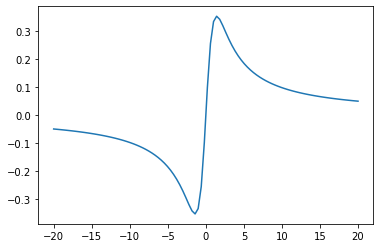

In [19]:
import matplotlib.pyplot as plt
a = np.linspace(-20, 20, 100)
plt.plot(a, 2*a / (2*a**2+4))

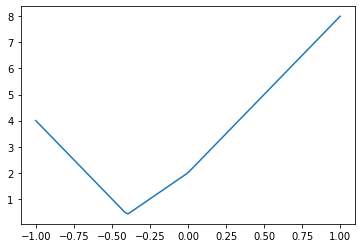

In [20]:
# l1 reg on ccm res
a = -0.4
t = np.linspace(-1, 1, 100)
plt.plot(t, np.abs(-1 + t/a) + np.abs(1-t/a) + np.abs(t))

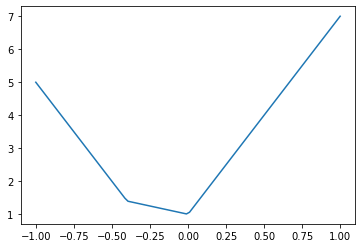

In [21]:
# l1 reg
a = -0.4
t = np.linspace(-1, 1, 100)
plt.plot(t, np.abs(t/a) + np.abs(1-t/a) + np.abs(t))

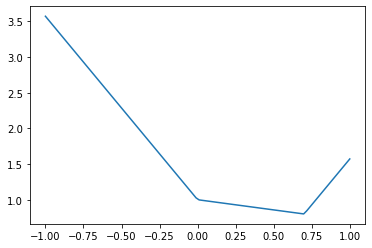

In [22]:
# weighte l1 reg
a = 0.7
b = 0.1
t = np.linspace(-1, 1, 100)
plt.plot(t, b * np.abs(t/a) + np.abs(1-t/a) + np.abs(t))

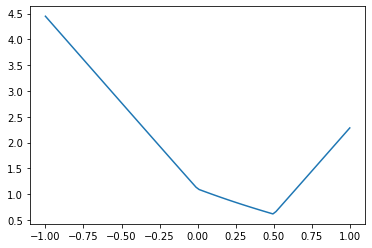

In [23]:
# EYE
a = 0.5
b = 0.1
t = np.linspace(-1, 1, 100)
plt.plot(t, b * np.sqrt((t/a)**2 + (np.abs(1-t/a) + np.abs(t))**2) + np.abs(1-t/a) + np.abs(t))